In [13]:
# PASTE THIS TO THE FIRST CELL OF THE NOTEBOOK IN ORDER TO HAVE WORKING IMPORTS
import sys
import os
current_dir = os.getcwd()
parent_parent_dir = os.path.abspath(os.path.join(current_dir, '../..')) # tweak so that you get the root project folder

sys.path.append(parent_parent_dir)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from src.features.get_x_y_tuples import * 
from sklearn.cluster import OPTICS
from src.models.clustering_optimization.optimize_optics import *
from matplotlib.gridspec import GridSpec
from src.visualization.get_cluster_colors import get_cluster_colors
from src.visualization.get_cluster_legend_handles import get_cluster_legend_handles
from src.visualization.format_optimization_input_params_to_text import *
from src.visualization.format_clustering_parameter_dict_to_text import *
from src.models.clustering_optimization.optimize_optics_parallelized import *
from src.models.clustering_optimization.optimize_optics_parallelized_punish_non_edge_points import *



In [15]:
# 1. load into dataframe
df_cuid = pd.read_csv('../../data/processed/k733_2020_cuid.csv')
df_cuid_grouped = pd.read_csv('../../data/processed/k733_2020_cuid_grouped.csv')
# 2. transform values to numbers
df_cuid_grouped['x'] = df_cuid_grouped['x'].apply(lambda x: ast.literal_eval(x))
df_cuid_grouped['y'] = df_cuid_grouped['y'].apply(lambda y: ast.literal_eval(y))

# 3. create tuple lists
list_k729_2022_x_y_tuples = get_x_y_tuple_list(df_cuid_grouped, ['x','y'])


In [16]:
from src.features.get_first_and_last_x_y_coordinates import *
from src.features.get_first_coordinates import get_first_x_y_coordinates
from src.features.get_last_coordinates import get_last_x_y_coordinates

first_last_x_coords, first_last_y_coords = get_first_and_last_x_y_coordinates(list_k729_2022_x_y_tuples)
X = np.array([first_last_x_coords, first_last_y_coords]).T


# OPTICS OPTIMIZATION PARALLEL WITH NOISE

### optimization params

In [17]:
max_eps_range = np.arange(0.1, 5, 0.1)
min_samples_range = np.arange(10, 30, 1)
metric='euclidean'
cluster_method = 'dbscan'
xi=0.05

### optimize

In [18]:
optics_optimization_results = optimize_optics_parallelized(X, max_eps_range, min_samples_range, metric, cluster_method)

### manual optimization results to not run it everytime

In [19]:
# optics_optimization_results = tbd

### Cluster with the optimized params

In [20]:
# Extracting all optimized scores in a more concise way
score_optimized_silhouette, epsilon_optimized_silhouette, min_samples_optimized_silhouette = optics_optimization_results['silhouette'].values()
score_optimized_calinski_harabasz, epsilon_optimized_calinski_harabasz, min_samples_optimized_calinski_harabasz = optics_optimization_results['calinski_harabasz'].values()
score_optimized_davies_bouldin, epsilon_optimized_davies_bouldin, min_samples_optimized_davies_bouldin = optics_optimization_results['davies_bouldin'].values()
score_optimized_bic, epsilon_optimized_bic, min_samples_optimized_bic = optics_optimization_results['bic'].values()
score_optimized_aic, epsilon_optimized_aic, min_samples_optimized_aic = optics_optimization_results['aic'].values()

In [21]:
# Helper function to fit OPTICS model and calculate labels and cluster centers
def fit_optics(epsilon, min_samples, X):
    optics = OPTICS(eps=epsilon, min_samples=min_samples, metric='euclidean', cluster_method='dbscan')
    optics.fit(X)
    labels = optics.labels_
    unique_labels = np.unique(labels[labels != -1])
    centers = np.array([X[labels == label].mean(axis=0) for label in unique_labels])
    return labels, centers

# Silhouette-based optimized OPTICS model
labels_silhouette, centers_silhouette = fit_optics(epsilon_optimized_silhouette, min_samples_optimized_silhouette, X)

# Calinski-Harabasz-based optimized OPTICS model
labels_calinski_harabasz, centers_calinski_harabasz = fit_optics(epsilon_optimized_calinski_harabasz, min_samples_optimized_calinski_harabasz, X)

# Davies-Bouldin-based optimized OPTICS model
labels_davies_bouldin, centers_davies_bouldin = fit_optics(epsilon_optimized_davies_bouldin, min_samples_optimized_davies_bouldin, X)

# BIC-based optimized OPTICS model
labels_bic, centers_bic = fit_optics(epsilon_optimized_bic, min_samples_optimized_bic, X)

# AIC-based optimized OPTICS model
labels_aic, centers_aic = fit_optics(epsilon_optimized_aic, min_samples_optimized_aic, X)


### create legend handles + colors

In [22]:
# plot the optimized optics cluster with the silhouette parameters
from src.visualization.get_cluster_colors import get_cluster_colors
from src.visualization.get_cluster_legend_handles import get_cluster_legend_handles


point_colors_start_end_silhouette_optimized, colors_start_end_silhouette_optimized = get_cluster_colors(labels_silhouette)
legend_handles_start_end_silhouette_optimized = get_cluster_legend_handles(colors_start_end_silhouette_optimized, labels_silhouette)

point_colors_start_end_calinski_harabasz_optimized, colors_start_end_calinski_harabasz_optimized = get_cluster_colors(labels_calinski_harabasz)
legend_handles_start_end_calinski_harabasz_optimized = get_cluster_legend_handles(colors_start_end_calinski_harabasz_optimized, labels_calinski_harabasz)

point_colors_start_end_davies_bouldin_optimized, colors_start_end_davies_bouldin_optimized = get_cluster_colors(labels_davies_bouldin)
legend_handles_start_end_davies_bouldin_optimized = get_cluster_legend_handles(colors_start_end_davies_bouldin_optimized, labels_davies_bouldin)

point_colors_start_end_bic_optimized, colors_start_end_bic_optimized = get_cluster_colors(labels_bic)
legend_handles_start_end_bic_optimized = get_cluster_legend_handles(colors_start_end_bic_optimized, labels_bic)

point_colors_start_end_aic_optimized, colors_start_end_aic_optimized = get_cluster_colors(labels_aic)
legend_handles_start_end_aic_optimized = get_cluster_legend_handles(colors_start_end_aic_optimized, labels_aic)

### create description texts

In [23]:
# Formatting optimization input parameters for OPTICS, including xi only if cluster_method is 'xi'
optimization_parameters_description = format_optimization_input_params_to_text(
    max_eps_range=max_eps_range, 
    min_samples_range=min_samples_range, 
    metric=metric, 
    cluster_method=cluster_method, 
    xi=xi if cluster_method == 'xi' else 'not applicable'
)

# Formatting clustering description for OPTICS optimization results
clustering_description = format_clustering_parameter_dict_to_text(optics_optimization_results)


### plot

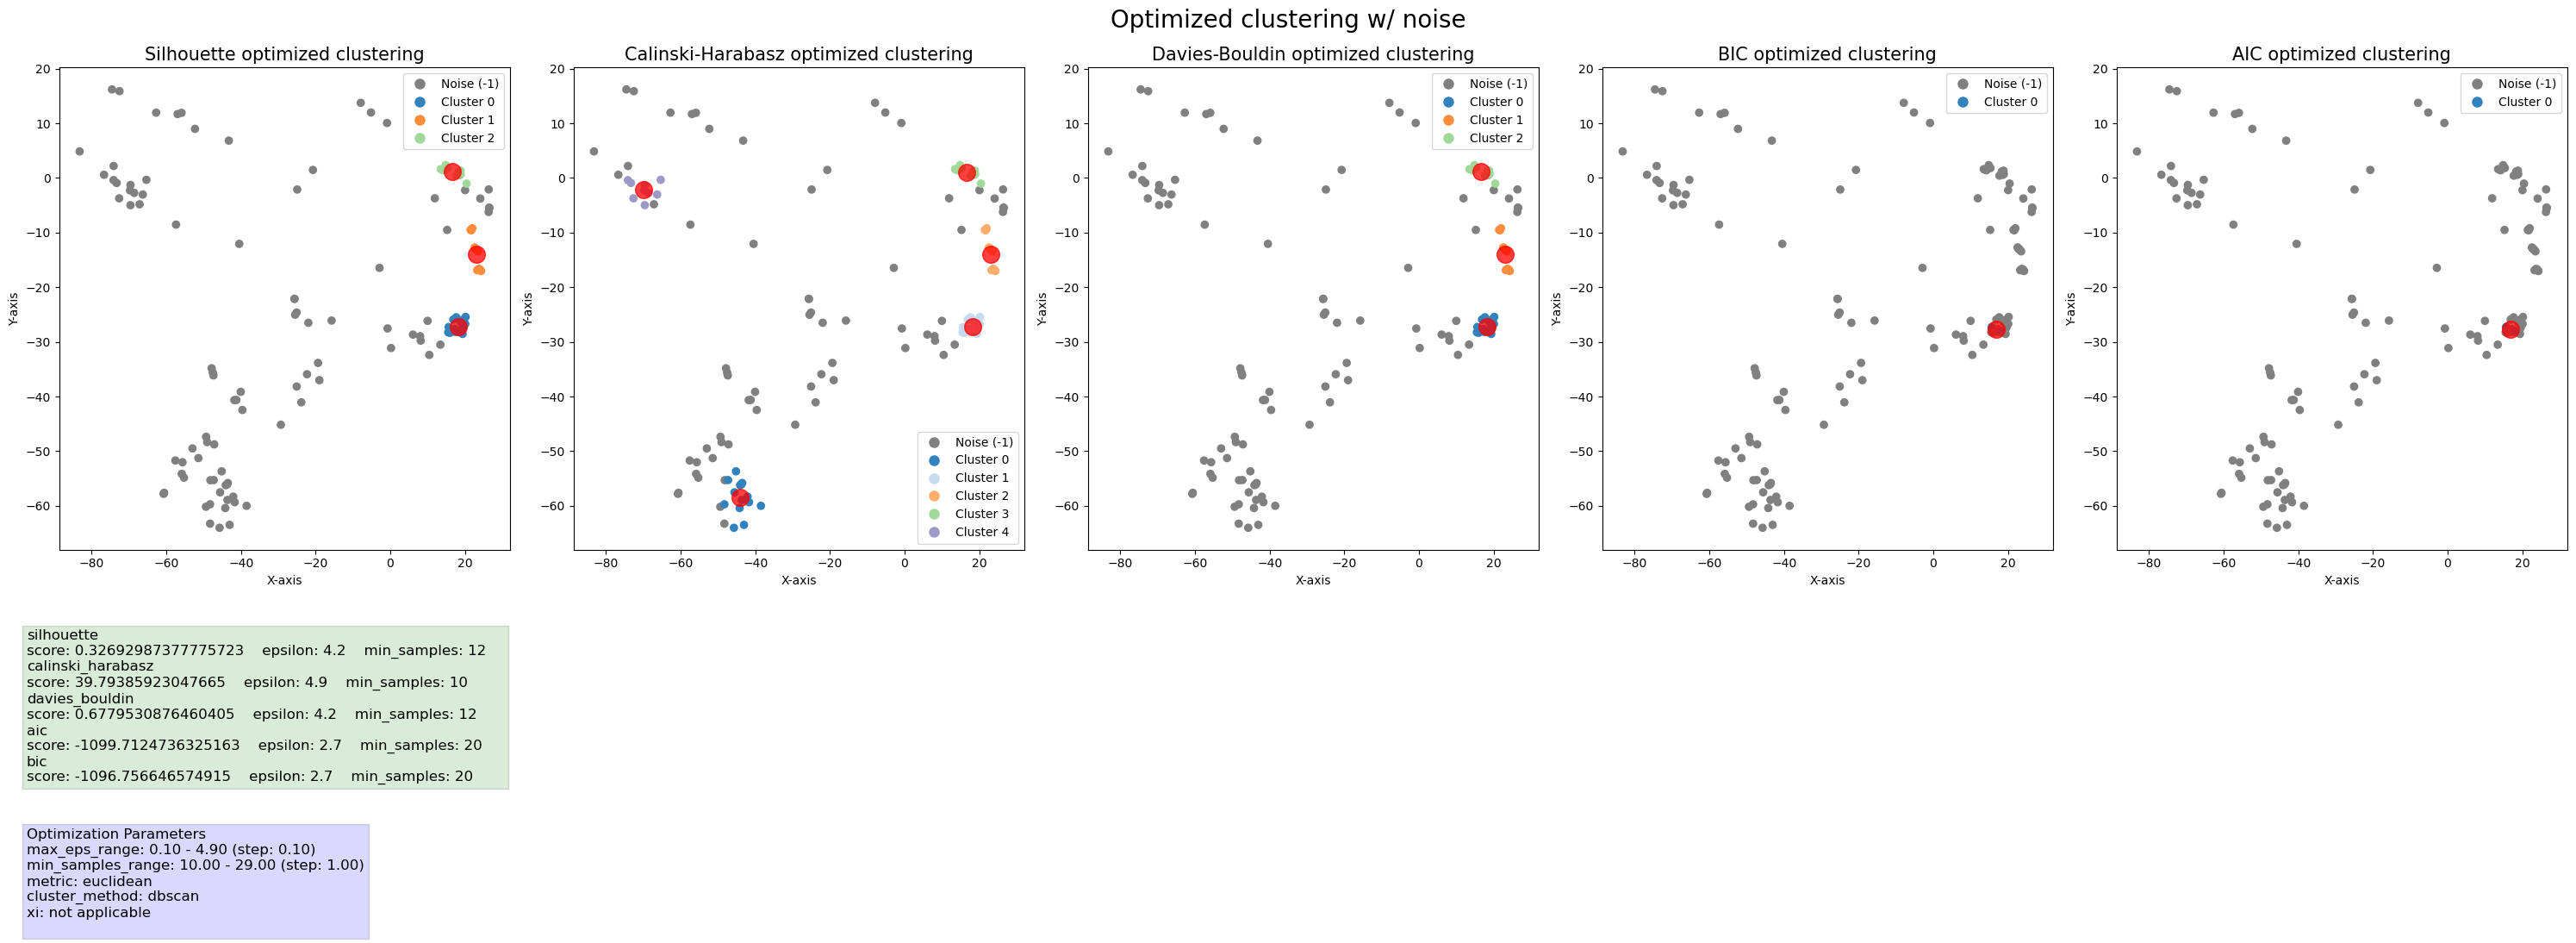

In [24]:
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(30, 7))
gs = GridSpec(1, 5, figure=fig)

ax1 = fig.add_subplot(gs[0, 0]) 
ax1.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_silhouette_optimized)
ax1.scatter(centers_silhouette[:, 0], centers_silhouette[:, 1], c='red', s=200, alpha=0.75, label='Cluster Centers')
ax1.set_title(f'Silhouette optimized clustering', fontsize=15)
ax1.set_xlabel("X-axis")
ax1.set_ylabel("Y-axis")
ax1.legend(handles=legend_handles_start_end_silhouette_optimized)

ax2 = fig.add_subplot(gs[0, 1])
ax2.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_calinski_harabasz_optimized)
ax2.scatter(centers_calinski_harabasz[:, 0], centers_calinski_harabasz[:, 1], c='red', s=200, alpha=0.75, label='Cluster Centers')
ax2.set_title(f'Calinski-Harabasz optimized clustering', fontsize=15)
ax2.set_xlabel("X-axis")
ax2.set_ylabel("Y-axis")
ax2.legend(handles=legend_handles_start_end_calinski_harabasz_optimized)

# Create the bottom right plot
ax3 = fig.add_subplot(gs[0, 2])  # Bottom right
ax3.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_davies_bouldin_optimized)
ax3.scatter(centers_davies_bouldin[:, 0], centers_davies_bouldin[:, 1], c='red', s=200, alpha=0.75, label='Cluster Centers')
ax3.set_title(f'Davies-Bouldin optimized clustering', fontsize=15)
ax3.set_xlabel("X-axis")
ax3.set_ylabel("Y-axis")
ax3.legend(handles=legend_handles_start_end_davies_bouldin_optimized)

ax4 = fig.add_subplot(gs[0, 3])  # Bottom right
ax4.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_bic_optimized)
ax4.scatter(centers_bic[:, 0], centers_bic[:, 1], c='red', s=200, alpha=0.75, label='Cluster Centers')
ax4.set_title(f'BIC optimized clustering', fontsize=15)
ax4.set_xlabel("X-axis")
ax4.set_ylabel("Y-axis")
ax4.legend(handles=legend_handles_start_end_bic_optimized)

ax5 = fig.add_subplot(gs[0, 4])  # Bottom right
ax5.scatter(first_last_x_coords, first_last_y_coords, c=point_colors_start_end_aic_optimized)
ax5.scatter(centers_aic[:, 0], centers_aic[:, 1], c='red', s=200, alpha=0.75, label='Cluster Centers')
ax5.set_title(f'AIC optimized clustering', fontsize=15)
ax5.set_xlabel("X-axis")
ax5.set_ylabel("Y-axis")
ax5.legend(handles=legend_handles_start_end_aic_optimized)

props_results = dict(boxstyle='square', facecolor='green', alpha=0.15)
fig.text(0.012,-0.3,f'{clustering_description}', fontsize=12, bbox=props_results)
props_optimization_parameters = dict(boxstyle='square', facecolor='blue', alpha=0.15)
fig.text(0.012,-0.55,f'Optimization Parameters\n{optimization_parameters_description}', fontsize=12, bbox=props_optimization_parameters)
plt.suptitle(f'Optimized clustering w/ noise', fontsize=20)


# Display the plots
plt.tight_layout()
plt.show()